# Vanilla Convolutional Autoencoder

**Authors:** KHOO Jing Heng, Zayne SIEW

**Version:** 1.0 (01/04/2025)

### About this notebook

This notebook implements a vanilla convolutional autoencoder (CAE) model for training on the ECoG data.

### Requirements

- Python 3
- Matplotlib
- Numpy
- Scipy
- Torch

## 0. Imports and Torch-CUDA Config

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from constants import (
    CHANNELS_NUM,
    ECOG_TRAIN_FILEPATH,
    ECOG_VAL_FILEPATH,
    FLEXION_TRAIN_FILEPATH,
    FLEXION_VAL_FILEPATH,
    SAMPLE_RATE,
    WAVELET_NUM,
)
from data import EcogDataset, plot_ecog_data
from eval import (
    cosine_correlation_metric,
    pearson_correlation_metric,
    plot_fingerwise_timeseries,
    test_model,
)
from model import EncoderDecoderVanilla

In [ ]:
# For windows/linux will try CUDA first, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Set default device for following code, so we don't need to specify device every time
torch.set_default_device(DEVICE)

## 1. Data Loading and Visualisation

In [3]:
# Define directory where data is stored
DATA_DIR = "../data"

finger_flex_cropped: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_TRAIN_FILEPATH}')
X_spectrogram_cropped: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_TRAIN_FILEPATH}')

finger_flex_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}')
X_spectrogram_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}')

In [5]:
train_dataset = EcogDataset(X_spectrogram_cropped, finger_flex_cropped)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)
print(len(train_dataset))

val_dataset = EcogDataset(X_spectrogram_cropped_val, finger_flex_cropped_val)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(62, 40, 39980) (5, 39980)
39724
(62, 40, 19980) (5, 19980)
19724


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

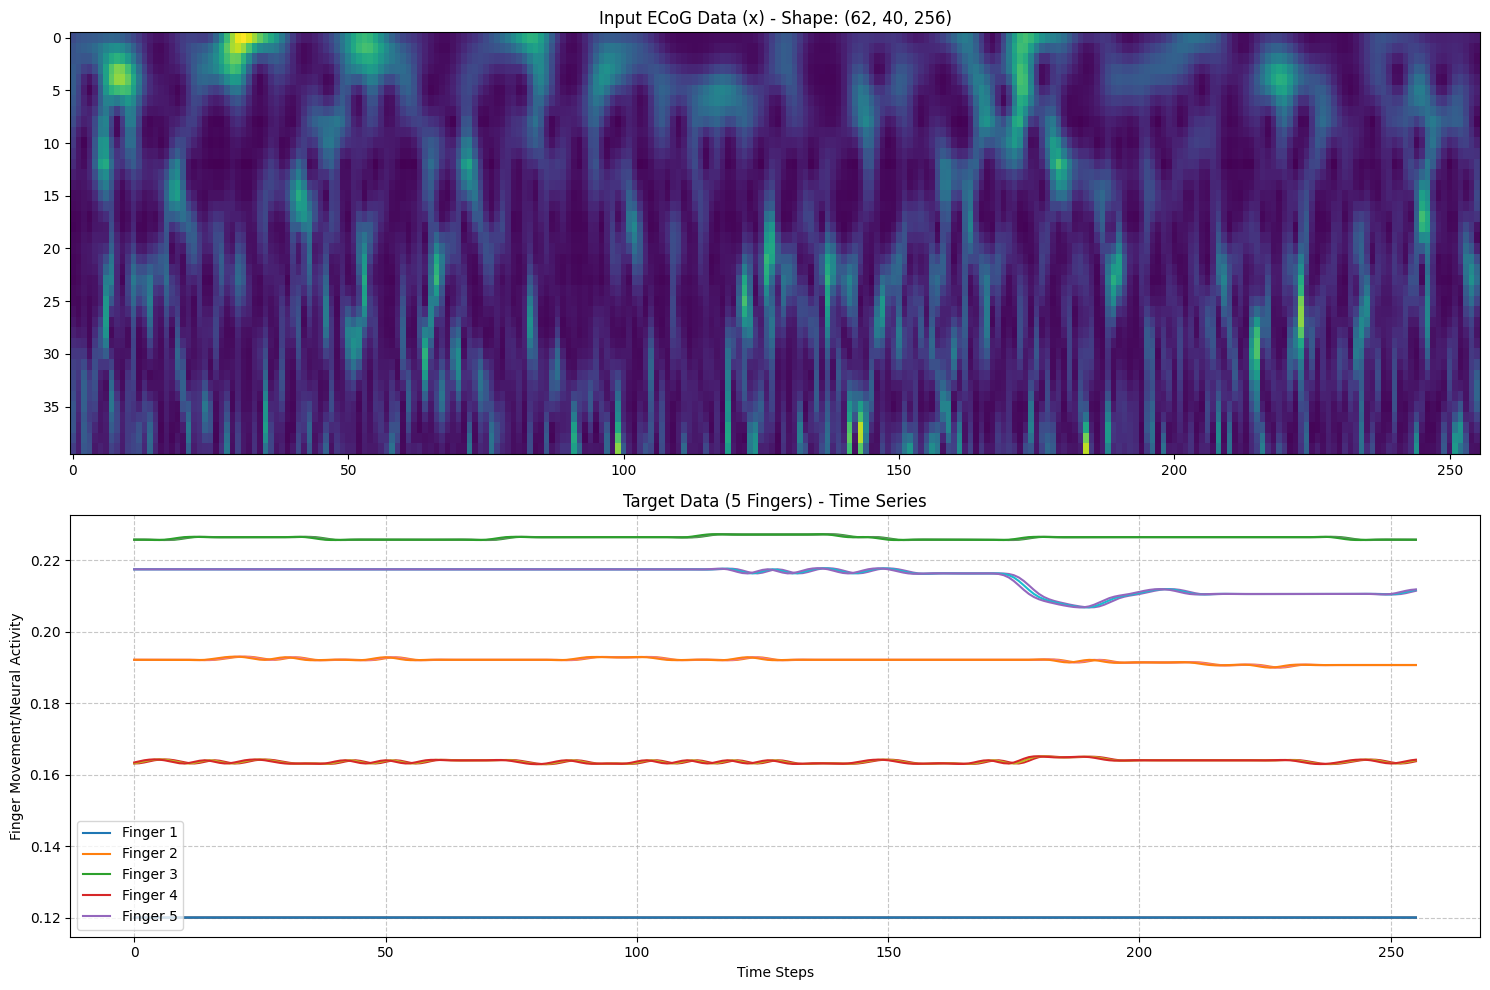

Input (x) Data Statistics:
Shape: (62, 40, 256)
Mean: 36.44956970214844
Std: 112.34618377685547
Min: -78.30249786376953
Max: 2913.20654296875

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.18342195451259613
Std: 0.038283176720142365
Min: 0.12006422877311707
Max: 0.22728414833545685


In [7]:
# Call the visualization function
plot_ecog_data(train_dataset)

## 2. Model Training

This section trains a new `EncoderDecoderVanilla` model.

In [ ]:
def train(
    model: EncoderDecoderVanilla,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 100,
    lr: float = 1e-3,
    device: torch.device = DEVICE,
    alpha: float = 0.5,
) -> EncoderDecoderVanilla:
    """Trains an instance of an `EncoderDecoderVanilla` model.

    This function also outputs evaluation metrics on the validation set while training.

    Parameters:
        model (EncoderDecoderVanilla):
            The `EncoderDecoderVanilla` model instance to train.
        train_lodaer (DataLoader):
            Dataloader of the training dataset.
        val_loader (DataLoader):
            Dataloader of the validation dataset.
        num_epochs (int, default=100):
            Number of epochs to train the model on.
        lr (float, default=1e-3):
            Learning rate of the `AdamW` optimiser.
        device (torch.device, default=DEVICE):
            Desired torch device to use for computation.
        alpha (float, default=0.5):
            Weightage in loss function between MSE loss and cosine similarity.

    Returns:
        EncoderDecoderVanilla:
            The trained model.
    """

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    train_losses, val_losses = [], []
    train_corrs, val_corrs = [], []
    pearson_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corr = 0.0

        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(x)

            mse_loss = F.mse_loss(pred, y)
            corr = cosine_correlation_metric(pred, y)
            final_loss = alpha*mse_loss + alpha*(1. - corr)

            # corr = pearson_loss(pred, y)
            # final_loss = alpha * mse_loss + (1 - alpha) * corr

            final_loss.backward()
            optimizer.step()

            train_loss += final_loss.item()
            train_corr += corr.item()

        train_loss /= len(train_loader)
        train_corr /= len(train_loader)
        train_losses.append(train_loss)
        train_corrs.append(train_corr)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Corr: {train_corr:.4f}")

        model.eval()
        val_loss = 0.0
        val_corr = 0.0
        pearson_loss_sum = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)

                pred = model(x)

                mse_loss = F.mse_loss(pred, y)
                corr = cosine_correlation_metric(pred, y)
                final_loss = alpha*mse_loss + alpha*(1. - corr)

                pearson_loss_metric = pearson_correlation_metric(pred, y)
                # final_loss = alpha * mse_loss + (1 - alpha) * corr

                val_loss += final_loss.item()
                val_corr += corr.item()
                pearson_loss_sum += pearson_loss_metric.item()

        val_loss /= len(val_loader)
        val_corr /= len(val_loader)
        pearson_loss_sum /= len(val_loader)

        val_losses.append(val_loss)
        val_corrs.append(val_corr)
        pearson_losses.append(pearson_loss_sum)

        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Corr: {val_corr:.4f}, Pearson Corr: {pearson_loss_sum:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot correlation metrics
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_corrs, label='Train Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), val_corrs, label='Val Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), pearson_losses, label='Val Corr', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Training, Validation, Pearson Correlation")

    plt.tight_layout()
    plt.show()

    return model

In [12]:
model = EncoderDecoderVanilla(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)
model = train(model, train_loader, val_loader, num_epochs=20)
# torch.save(model.state_dict(), "../encoder_decoder.pth")

Epoch 1/20 - Train Loss: 0.0766, Train Corr: 0.9065
Epoch 1/20 - Val Loss: 0.0392, Val Corr: 0.9470
Epoch 2/20 - Train Loss: 0.0185, Train Corr: 0.9706
Epoch 2/20 - Val Loss: 0.0405, Val Corr: 0.9466
Epoch 3/20 - Train Loss: 0.0120, Train Corr: 0.9807
Epoch 3/20 - Val Loss: 0.0410, Val Corr: 0.9449
Epoch 4/20 - Train Loss: 0.0099, Train Corr: 0.9841
Epoch 4/20 - Val Loss: 0.0399, Val Corr: 0.9462
Epoch 5/20 - Train Loss: 0.0077, Train Corr: 0.9877
Epoch 5/20 - Val Loss: 0.0410, Val Corr: 0.9462
Epoch 6/20 - Train Loss: 0.0063, Train Corr: 0.9900
Epoch 6/20 - Val Loss: 0.0403, Val Corr: 0.9477
Epoch 7/20 - Train Loss: 0.0063, Train Corr: 0.9900
Epoch 7/20 - Val Loss: 0.0411, Val Corr: 0.9467
Epoch 8/20 - Train Loss: 0.0053, Train Corr: 0.9916
Epoch 8/20 - Val Loss: 0.0411, Val Corr: 0.9458
Epoch 9/20 - Train Loss: 0.0051, Train Corr: 0.9920
Epoch 9/20 - Val Loss: 0.0413, Val Corr: 0.9450
Epoch 10/20 - Train Loss: 0.0048, Train Corr: 0.9925
Epoch 10/20 - Val Loss: 0.0413, Val Corr: 0.945

KeyboardInterrupt: 

## 3. Model Validation

This section performs validation on the trained model using the test dataset.

In [ ]:
actuals, predictions = test_model(model, val_loader)
print(actuals.shape, predictions.shape)

(19724, 5, 256) (19724, 5, 256)


In [ ]:
# Print pearon correlation (SotA model 0.67)
print(pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)))

tensor(0.4098)


C:\Users\nutri\AppData\Local\Temp\ipykernel_20356\2858757896.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\nutri\AppData\Local\Temp\ipykernel_20356\2858757896.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
d:\Downloads\project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


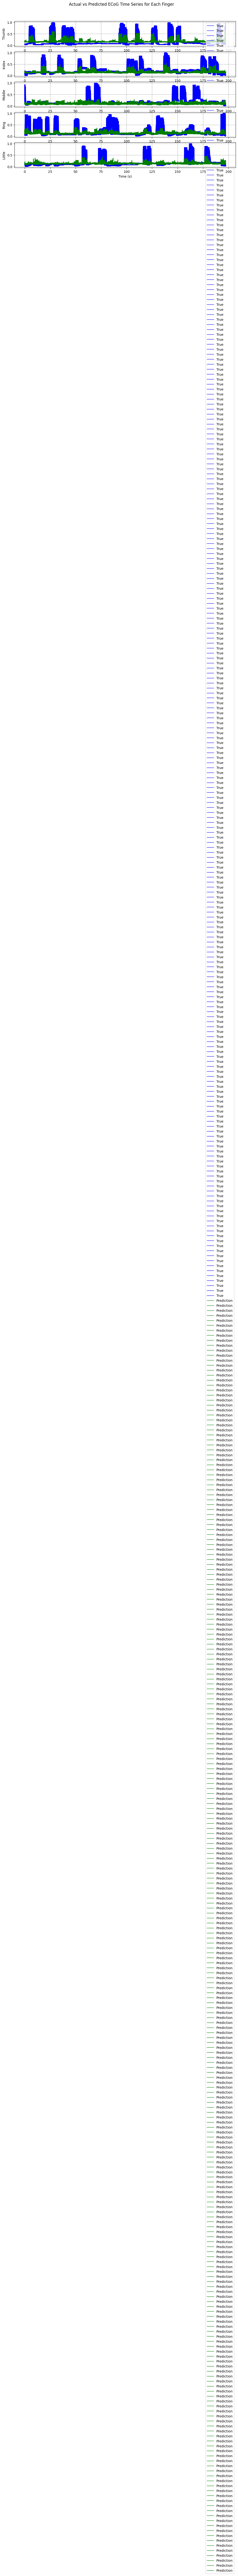

In [ ]:
# Plot the actual and predicted ECoG signals for each finger
time_axis = np.arange(actuals.shape[0]) / SAMPLE_RATE # Time axis in seconds
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis)